In [85]:
from tensorflow.keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Convolution2D, AveragePooling2D, GlobalAveragePooling2D 
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from tensorflow.keras.layers import BatchNormalization, Dropout
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import InceptionV3, VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications import ResNet50

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import tensorflow as tf
import random as rnd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from numpy import expand_dims

import os
from os import listdir
from os.path import isdir, isfile, join

In [78]:
def plot_augimages(paths, datagen):
### visualize augmented images generated using a Keras ImageDataGenerator ###
    plt.figure(figsize = (14,28))
    plt.suptitle('Augmented Images')
    
    midx = 0 # matplotlib index
    for path in paths:
        data = Image.open(path)
        data = data.resize((224,224))
        ''' add an extra dimension to the data array. 
        This step is often required to make the image compatible with the batch processing 
        expected by many deep learning models. The expand_dims function adds an additional 
        dimension at the beginning, effectively creating a batch of size 1 containing 
        the resized image.'''
        samples = expand_dims(data, 0) 
        '''This line sets up an iterator (it) using a Keras ImageDataGenerator (datagen). 
        The iterator is configured to generate batches of data from the samples array, 
        with each batch containing one image (batch_size=1). 
        This iterator can be used to generate augmented versions of the image during training.'''
        it = datagen.flow(samples, batch_size=1)
    
        # Show Original Image
        plt.subplot(10,5, midx+1)
        plt.imshow(data)
        plt.axis('off')
    
        # Show Augmented Images
        for idx, i in enumerate(range(4)):
            midx += 1
            plt.subplot(10,5, midx+1)
            
            batch = it.next()
            image = batch[0].astype('uint8') # extracts the image data from the batch
            plt.imshow(image)
            plt.axis('off')
        midx += 1
    
    plt.tight_layout()
    plt.show()

# Import data

In [25]:
main_path = r'D:\Praca\Data_Science\SDA_Kurs\Grapevine_leaves\Data\Train_val\\'
path_Ak = main_path + 'Ak'
path_Ala_Idris = main_path + 'Ala_Idris'
path_Buzgulu = main_path + 'Buzgulu'
path_Dimnit = main_path + 'Dimnit'
path_Nazli = main_path + 'Nazli'
test_data_dir = r'D:\Praca\Data_Science\SDA_Kurs\Grapevine_leaves\Data\Test'

In [26]:
path_Ak = main_path + 'Ak'
path_Ala_Idris = main_path + 'Ala_Idris'
path_Buzgulu = main_path + 'Buzgulu'
path_Dimnit = main_path + 'Dimnit'
path_Nazli = main_path + 'Nazli'

In [41]:
main_df = pd.DataFrame()

In [42]:
main_df['image'] = os.listdir(path_Ak) + os.listdir(path_Ala_Idris) + os.listdir(path_Buzgulu) + os.listdir(path_Dimnit) + os.listdir(path_Nazli)

In [43]:
main_df

,image
0,Ak (100).png
1,Ak (11).png
2,Ak (12).png
3,Ak (13).png
4,Ak (14).png
...,...
445,Nazli (95).png
446,Nazli (96).png
447,Nazli (97).png
448,Nazli (98).png


In [44]:
classes = []
paths = []
for image in main_df['image']:
    class_ = image.split(' (')[0]
    classes.append(class_)
    paths.append(main_path+class_+'\\'+image)

In [45]:
main_df['class'] = classes
main_df['path'] = paths

In [46]:
main_df.sample(5)

,image,class,path
229,Buzgulu (59).png,Buzgulu,D:\Praca\Data_Science\SDA_Kurs\Grapevine_leave...
295,Dimnit (35).png,Dimnit,D:\Praca\Data_Science\SDA_Kurs\Grapevine_leave...
384,Nazli (34).png,Nazli,D:\Praca\Data_Science\SDA_Kurs\Grapevine_leave...
377,Nazli (27).png,Nazli,D:\Praca\Data_Science\SDA_Kurs\Grapevine_leave...
141,Ala_Idris (61).png,Ala_Idris,D:\Praca\Data_Science\SDA_Kurs\Grapevine_leave...


In [47]:
main_df['class'].value_counts()

class
Ak           90
Ala_Idris    90
Buzgulu      90
Dimnit       90
Nazli        90
Name: count, dtype: int64

In [48]:
main_df['class'].unique()

array(['Ak', 'Ala_Idris', 'Buzgulu', 'Dimnit', 'Nazli'], dtype=object)

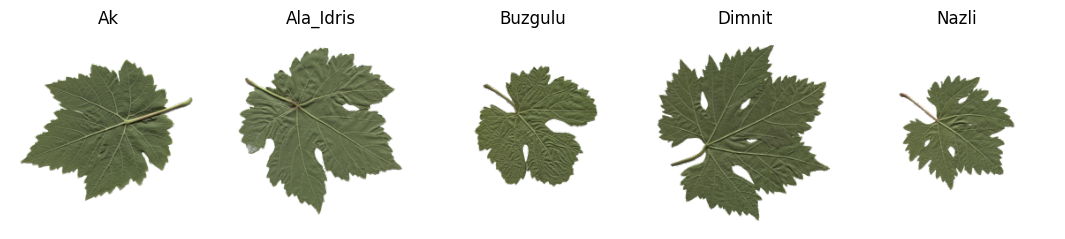

In [56]:
# Display a sample image from each class
plt.figure(figsize = (15,12))
for idx, i in enumerate(main_df['class'].unique()):
    plt.subplot(4,7,idx+1)
    df = main_df[main_df['class'] == i].reset_index(drop = True)
    image_path = df.loc[rnd.randint(0, len(df))-1,'path']
    img = Image.open(image_path)
    img = img.resize((224,224))
    plt.imshow(img)
    plt.axis('off')
    plt.title(i)
plt.tight_layout()
plt.show()

In [59]:
# add images' widths and heights to main_df
widths, heights = [], []

for path in tqdm(main_df["path"]):
    width, height = Image.open(path).size
    widths.append(width)
    heights.append(height)
    
main_df["width"] = widths
main_df["height"] = heights
main_df["dimension"] = main_df["width"] * main_df["height"]

100%|███████████████████████████████████████████████████████████████████████████████| 450/450 [00:00<00:00, 578.38it/s]


In [63]:
print(main_df['width'].unique())
print(main_df['height'].unique())

[511]
[511]


# Split the data

In [68]:
X_train, X_val, y_train, y_val = train_test_split(main_df[['path', 'class']], 
                                                  main_df[['class']], 
                                                  test_size=0.2)

# Generators

In [70]:
resnet50_datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.10,
    brightness_range=[0.6,1.4],
    channel_shift_range=0.7,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
) 

train_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
        X_train,  # This is the source directory for training images
        x_col='path',
        y_col='class',
        target_size=(227, 227),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)
val_generator_resnet50 = resnet50_datagen.flow_from_dataframe(
        X_val,  # This is the source directory for training images
        x_col='path',
        y_col='class',
        target_size=(227, 227),  # All images will be resized to 150x150
        batch_size=32,
        class_mode="categorical",
        shuffle=True,
)

Found 360 validated image filenames belonging to 5 classes.
Found 90 validated image filenames belonging to 5 classes.


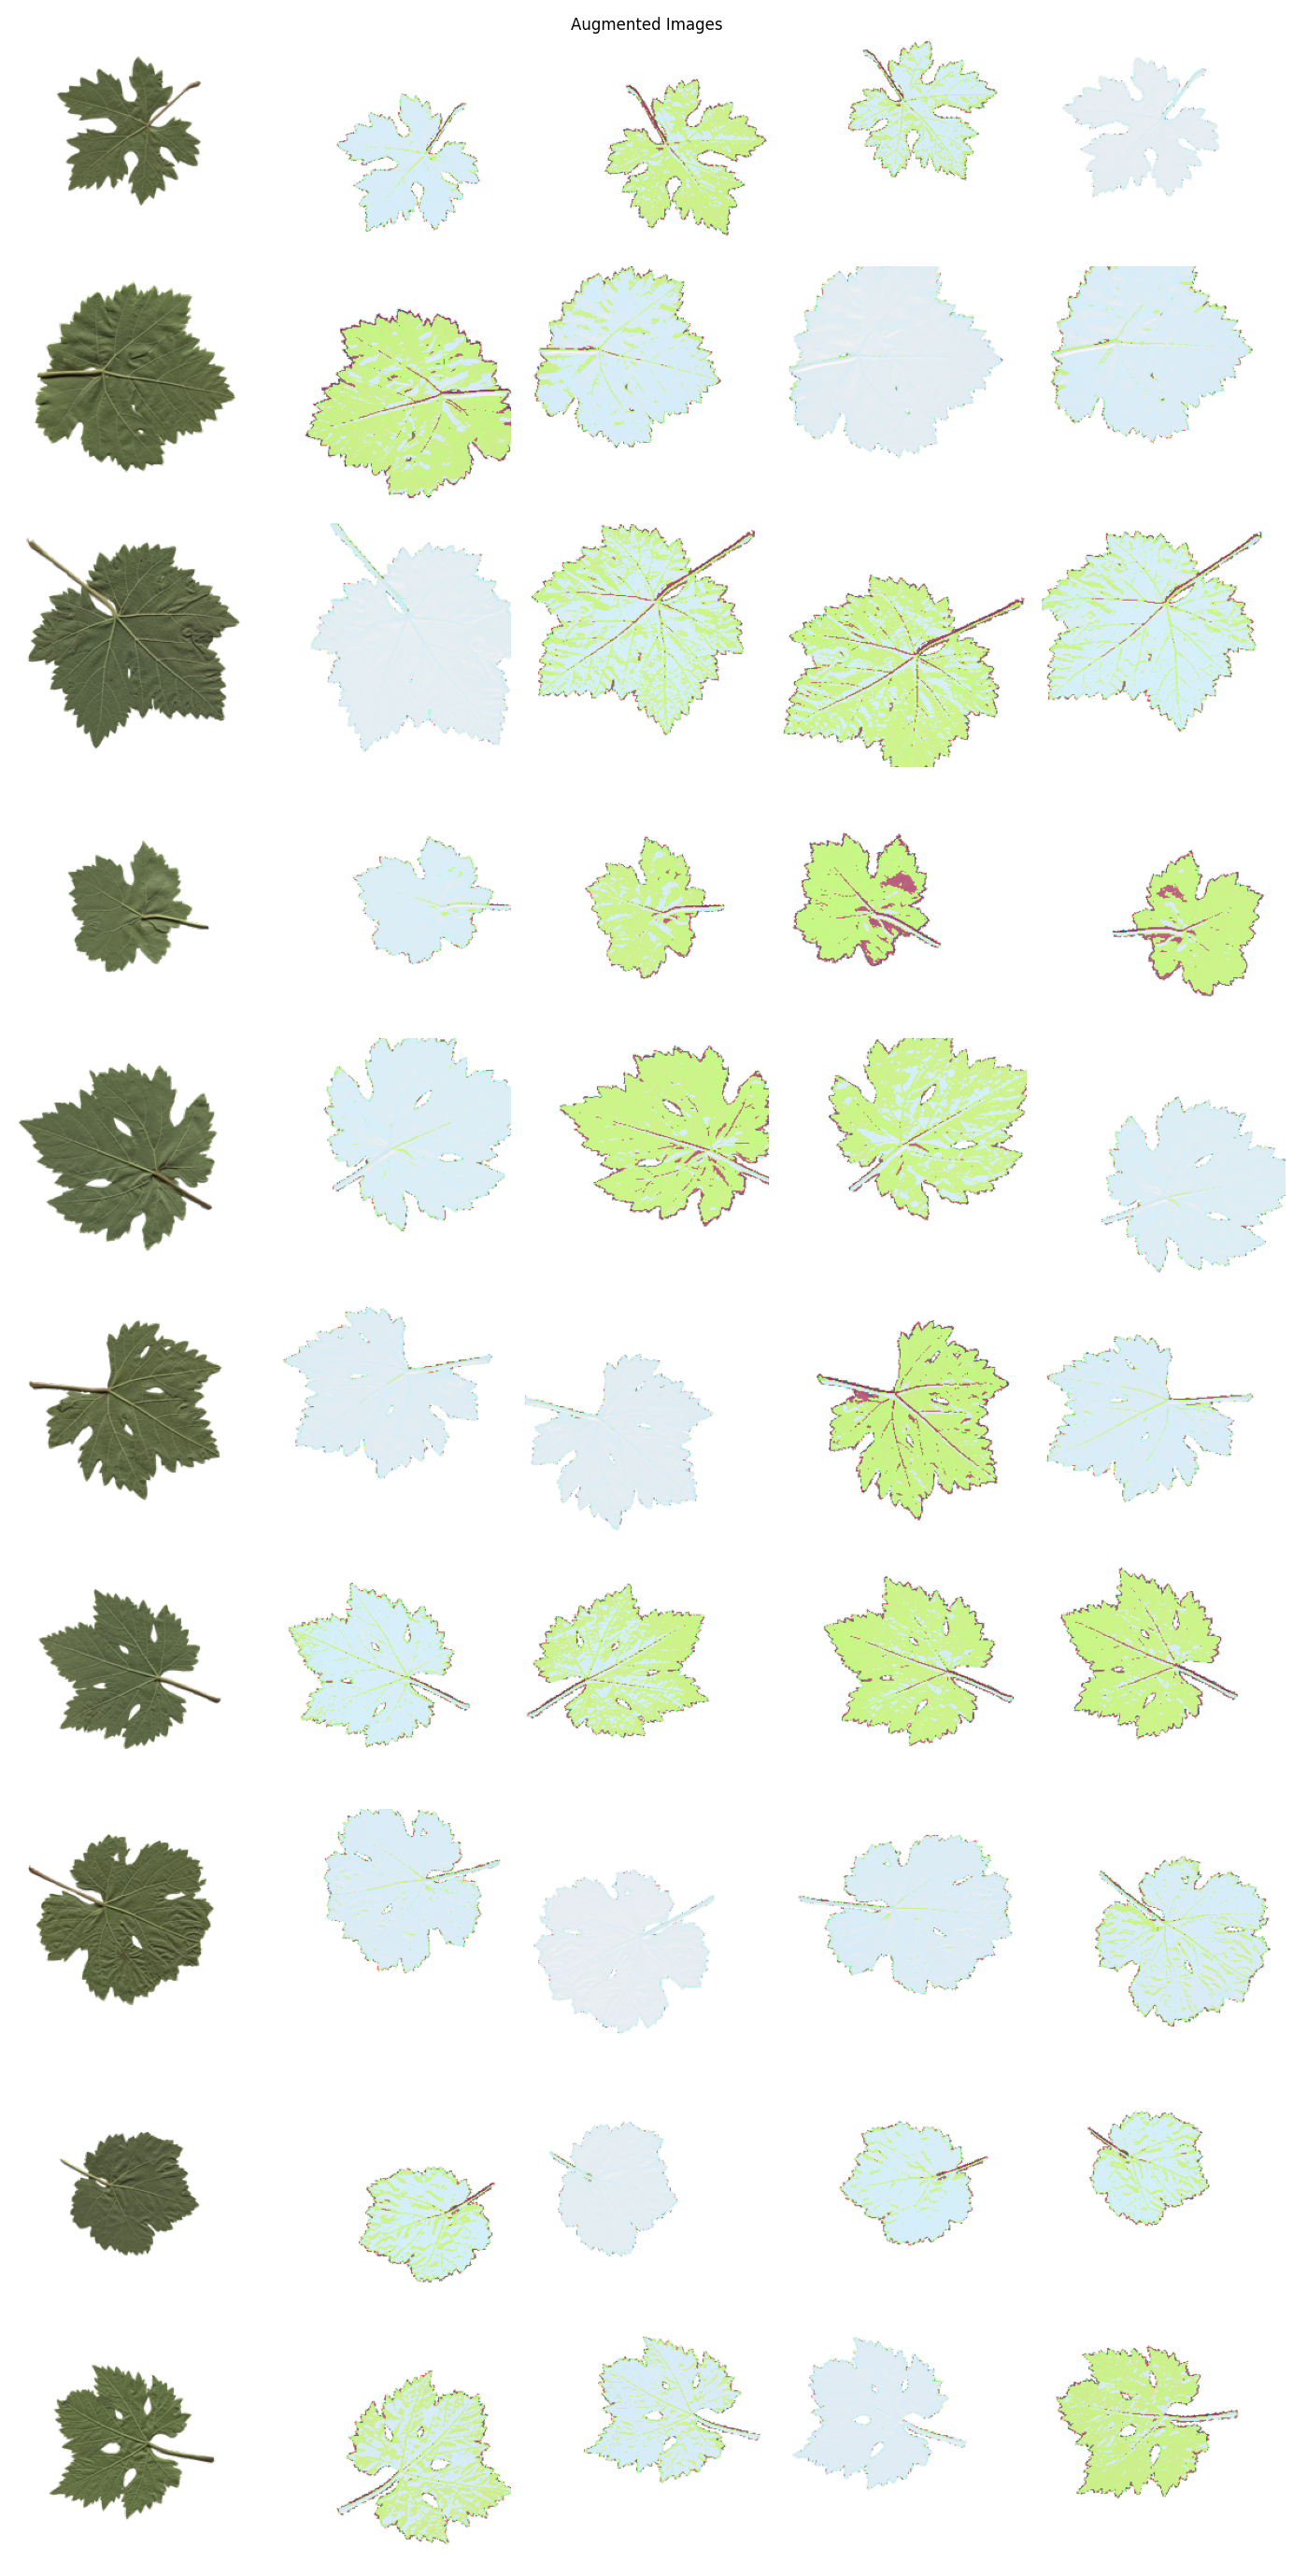

In [79]:
plot_augimages(np.random.choice(main_df['path'],10), resnet50_datagen)

In [86]:
# exclude the top (output) layer of the model
# initialize the model's weights with pre-trained weights from the ImageNet dataset
resnet50 = ResNet50(include_top = False, input_shape = (227,227,3), weights = 'imagenet')

# training of all the convolution is set to false
for layer in resnet50.layers:
    layer.trainable = False

x = GlobalAveragePooling2D()(resnet50.output)
predictions = Dense(5, activation='softmax')(x)

# the output tensor of the pre-trained ResNet-50 model
model_resnet50 = Model(inputs = resnet50.input, outputs = predictions)

## Model compilation

In [87]:
model_resnet50.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

## Model training

In [88]:
history_resnet50 = model_resnet50.fit(
      train_generator_resnet50,
      validation_data=val_generator_resnet50,
      epochs=20,
      verbose=2) #verbose=2 means that training progress will be displayed for each epoch, including metrics like loss and accuracy.

Epoch 1/20
12/12 - 81s - loss: 1.7456 - accuracy: 0.2306 - val_loss: 1.6067 - val_accuracy: 0.2667 - 81s/epoch - 7s/step
Epoch 2/20
12/12 - 80s - loss: 1.4574 - accuracy: 0.3694 - val_loss: 1.4242 - val_accuracy: 0.3778 - 80s/epoch - 7s/step
Epoch 3/20
12/12 - 95s - loss: 1.2770 - accuracy: 0.4667 - val_loss: 1.3354 - val_accuracy: 0.4000 - 95s/epoch - 8s/step
Epoch 4/20
12/12 - 101s - loss: 1.1703 - accuracy: 0.5722 - val_loss: 1.2031 - val_accuracy: 0.4778 - 101s/epoch - 8s/step
Epoch 5/20
12/12 - 124s - loss: 1.0255 - accuracy: 0.6778 - val_loss: 1.1890 - val_accuracy: 0.5222 - 124s/epoch - 10s/step
Epoch 6/20
12/12 - 113s - loss: 0.9754 - accuracy: 0.6667 - val_loss: 1.0811 - val_accuracy: 0.5778 - 113s/epoch - 9s/step
Epoch 7/20
12/12 - 114s - loss: 0.9348 - accuracy: 0.6806 - val_loss: 1.0502 - val_accuracy: 0.6556 - 114s/epoch - 10s/step
Epoch 8/20
12/12 - 108s - loss: 0.8432 - accuracy: 0.7278 - val_loss: 0.9257 - val_accuracy: 0.6667 - 108s/epoch - 9s/step
Epoch 9/20
12/12 - 1

# Previous approach

In [8]:
train_gen = datagen.flow_from_directory(
    train_data_dir, 
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes=CLASSES,
    subset='training',
    shuffle=True
)

validation_gen = datagen.flow_from_directory(
    train_data_dir,
    target_size=IMAGE_SHAPE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    classes = CLASSES,
    subset='validation',
    shuffle=True
)

test_gen = datagen.flow_from_directory(
    test_data_dir,
    target_size=IMAGE_SHAPE,
    batch_size=1,
    class_mode=None,
    shuffle=False
)

Found 405 images belonging to 5 classes.
Found 45 images belonging to 5 classes.
Found 50 images belonging to 1 classes.


## Inception model

In [10]:
inception_v3 = InceptionV3(include_top= False , weights= None , input_shape = (img_width , img_height , 3))

In [16]:
inception_v3.load_weights('inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

In [17]:
#freezing the layers so that they are not affected by the training on the new dataset
for layer in inception_v3.layers:
    layer.trainable = False

In [18]:
last_layer = inception_v3.get_layer('mixed7') #I will put my output nodes on this layer
last_output = last_layer.output

In [19]:
x = tf.keras.layers.Flatten()(last_output)
x = tf.keras.layers.Dense(100 , activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(5 , activation = 'softmax')(x)
pre_trained_model = tf.keras.models.Model(inputs = inception_v3.input , outputs = x)

In [20]:
pre_trained_model.compile(loss = tf.keras.losses.categorical_crossentropy , optimizer = tf.keras.optimizers.Adam() , metrics = ['accuracy'])

In [23]:
history_pre_trained = pre_trained_model.fit(train_gen , epochs = EPOCHS , validation_data= validation_gen)

Epoch 1/20
7/7 [==============================] - 78s 10s/step - loss: 16.8445 - accuracy: 0.2025 - val_loss: 4.6380 - val_accuracy: 0.2000
Epoch 2/20
7/7 [==============================] - 69s 10s/step - loss: 3.7769 - accuracy: 0.2123 - val_loss: 2.0487 - val_accuracy: 0.2222
Epoch 3/20
7/7 [==============================] - 76s 11s/step - loss: 1.7101 - accuracy: 0.1679 - val_loss: 1.6048 - val_accuracy: 0.1778
Epoch 4/20
7/7 [==============================] - 75s 10s/step - loss: 1.5845 - accuracy: 0.2296 - val_loss: 1.5701 - val_accuracy: 0.2000
Epoch 5/20
7/7 [==============================] - 79s 11s/step - loss: 1.6637 - accuracy: 0.2000 - val_loss: 1.6158 - val_accuracy: 0.1333
Epoch 6/20
7/7 [==============================] - 76s 12s/step - loss: 1.5770 - accuracy: 0.2123 - val_loss: 1.5616 - val_accuracy: 0.2000
Epoch 7/20
7/7 [==============================] - 77s 11s/step - loss: 1.5735 - accuracy: 0.2000 - val_loss: 1.5674 - val_accuracy: 0.1111
Epoch 8/20
7/7 [==========

## BASIC SEQUENTIAL MODEL

In [42]:
model = Sequential()

# Add a 2D convolutional layer with 32 filters of size 3x3 and ReLU activation function
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))

# Add a MaxPooling layer to reduce the data size
model.add(MaxPooling2D((2, 2)))

# Add another 2D convolutional layer with 64 filters of size 3x3 and ReLU activation
model.add(Conv2D(64, (3, 3), activation='relu'))

# Add another MaxPooling layer
model.add(MaxPooling2D((2, 2)))

# Add a 2D convolutional layer with 128 filters of size 3x3 and ReLU activation
model.add(Conv2D(128, (3, 3), activation='relu'))

# Add another MaxPooling layer
model.add(MaxPooling2D((2, 2)))

# Flatten the data into a one-dimensional array
model.add(Flatten())

# Add a dense layer with 512 units and ReLU activation
model.add(Dense(512, activation='relu'))

# Add an output layer with one neuron and a sigmoid activation function (binary classification)
model.add(Dense(len(CLASSES), activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.0001), 
              metrics=['accuracy'])


In [43]:
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=EPOCHS,
    validation_data=validation_gen,
    validation_steps=len(validation_gen)
)

Epoch 1/20
13/13 [==============================] - 93s 7s/step - loss: 2.5140 - accuracy: 0.1926 - val_loss: 1.6024 - val_accuracy: 0.2667
Epoch 2/20
13/13 [==============================] - 85s 6s/step - loss: 1.6291 - accuracy: 0.2049 - val_loss: 1.6167 - val_accuracy: 0.2000
Epoch 3/20
13/13 [==============================] - 79s 6s/step - loss: 1.5501 - accuracy: 0.3037 - val_loss: 1.6001 - val_accuracy: 0.2222
Epoch 4/20
13/13 [==============================] - 82s 6s/step - loss: 1.4948 - accuracy: 0.3506 - val_loss: 1.6107 - val_accuracy: 0.2222
Epoch 5/20
13/13 [==============================] - 82s 6s/step - loss: 1.3841 - accuracy: 0.5062 - val_loss: 1.5744 - val_accuracy: 0.2444
Epoch 6/20
13/13 [==============================] - 94s 7s/step - loss: 1.2700 - accuracy: 0.5457 - val_loss: 1.5926 - val_accuracy: 0.2889
Epoch 7/20
13/13 [==============================] - 142s 11s/step - loss: 1.1125 - accuracy: 0.6272 - val_loss: 1.5770 - val_accuracy: 0.2222
Epoch 8/20
13/13 [

In [45]:
model.save('basic_model.keras')

# Model 1

### WITH DROPOUTS, BATCH_NORM AND EARLY STOPPING

In [52]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(len(CLASSES), activation='softmax'))

In [53]:
# Compile the model
opt = tf.keras.optimizers.SGD(lr=0.001, momentum=0.9)
model.compile(loss='categorical_crossentropy', 
              optimizer=opt, 
              metrics=['accuracy'])

STEP_SIZE_TRAIN=train_gen.n//train_gen.batch_size
STEP_SIZE_VALID=validation_gen.n//validation_gen.batch_size

history = model.fit_generator(generator=train_gen,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=validation_gen,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=EPOCHS,
                    callbacks=[callback],
                    verbose=1
)

C:\Users\Katarzyna\AppData\Local\Temp\ipykernel_2984\2730287419.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(generator=train_gen,


Epoch 1/20
12/12 [==============================] - 114s 9s/step - loss: 2.2249 - accuracy: 0.2895 - val_loss: 15.8087 - val_accuracy: 0.2188
Epoch 2/20
12/12 [==============================] - 102s 8s/step - loss: 0.9912 - accuracy: 0.6193 - val_loss: 36.8633 - val_accuracy: 0.1875
Epoch 3/20
12/12 [==============================] - 115s 10s/step - loss: 0.7851 - accuracy: 0.7109 - val_loss: 26.3906 - val_accuracy: 0.1562
Epoch 4/20
12/12 [==============================] - 130s 11s/step - loss: 0.5943 - accuracy: 0.8043 - val_loss: 29.2213 - val_accuracy: 0.2812
Epoch 5/20
12/12 [==============================] - 152s 13s/step - loss: 0.3909 - accuracy: 0.8794 - val_loss: 22.2857 - val_accuracy: 0.2188
Epoch 6/20
12/12 [==============================] - 145s 12s/step - loss: 0.2531 - accuracy: 0.9115 - val_loss: 16.4876 - val_accuracy: 0.3125
Epoch 7/20
12/12 [==============================] - 134s 11s/step - loss: 0.1181 - accuracy: 0.9740 - val_loss: 14.9828 - val_accuracy: 0.1875
E

In [54]:
model.save('model1.keras')

In [55]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(len(CLASSES), activation='softmax'))

model.compile(loss='categorical_crossentropy', 
              optimizer=Adam(learning_rate=0.0001), 
              metrics=['accuracy'])

# Model 2

In [56]:
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=EPOCHS,
    validation_data=validation_gen,
    validation_steps=len(validation_gen)
)

Epoch 1/20
13/13 [==============================] - 261s 19s/step - loss: 2.0993 - accuracy: 0.3704 - val_loss: 1.7191 - val_accuracy: 0.2444
Epoch 2/20
13/13 [==============================] - 228s 17s/step - loss: 0.6250 - accuracy: 0.7951 - val_loss: 2.3985 - val_accuracy: 0.2000
Epoch 3/20
13/13 [==============================] - 199s 15s/step - loss: 0.2955 - accuracy: 0.9210 - val_loss: 3.5069 - val_accuracy: 0.2000
Epoch 4/20
13/13 [==============================] - 190s 15s/step - loss: 0.1333 - accuracy: 0.9877 - val_loss: 4.5011 - val_accuracy: 0.2000
Epoch 5/20
13/13 [==============================] - 188s 14s/step - loss: 0.0619 - accuracy: 0.9926 - val_loss: 4.9750 - val_accuracy: 0.2000
Epoch 6/20
13/13 [==============================] - 204s 16s/step - loss: 0.0322 - accuracy: 0.9975 - val_loss: 4.8684 - val_accuracy: 0.2000
Epoch 7/20
13/13 [==============================] - 207s 15s/step - loss: 0.0198 - accuracy: 0.9975 - val_loss: 5.0436 - val_accuracy: 0.1556
Epoch 

KeyboardInterrupt: 